In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

warnings.filterwarnings("ignore")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

DIR_INPUT = '/home/ubuntu/data_dicom'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
import os
file_list = os.listdir(DIR_TRAIN)
len(file_list)

1914

In [3]:
file_name = []
for file in file_list:
    if file.count(".") == 1: 
        name = file.split('.')[0]
        file_name.append(name)
    else:
        for k in range(len(file)-1,0,-1):
            if file[k]=='.':
                file_name.append(file[:k])
                break
                
len(file_name)

1914

In [4]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

# FasterRCNN handles class_id==0 as the background.
train_df["class_id"] = train_df["class_id"] + 1
train_df.loc[train_df["class_id"] == 15, ["class_id"]] = 0

print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)
len(train_df)

df Shape: (67914, 8)
No Of Classes: 15


67914

In [5]:
train_df2 = train_df[train_df['image_id'].isin(file_name)]
len(train_df2)

8668

In [6]:
train_df= train_df2
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,12,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,6,R17,1347.0,245.0,2188.0,2169.0
34,2b1293d9c276e5439e499f58ce2e31ab,No finding,0,R8,0.0,0.0,1.0,1.0
41,04bb8bd7ee6f88a16623fe5c6dd4da91,Pleural effusion,11,R10,655.0,1188.0,1354.0,2049.0
68,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,1,R9,1142.0,738.0,1451.0,1119.0
...,...,...,...,...,...,...,...,...
67850,2ba09f4a64b4d6268cf891974fa9bad9,No finding,0,R15,0.0,0.0,1.0,1.0
67864,3eaab50f6e8eb3229e752d546e41979b,ILD,6,R10,676.0,552.0,1082.0,1483.0
67876,2b54a107cfa7753b2f625a4fd122df3a,No finding,0,R4,0.0,0.0,1.0,1.0
67899,3b887c0550e9722c9b86b7c22ad09e11,Other lesion,10,R10,254.0,1959.0,280.0,1990.0


In [7]:
def label_to_name(id):
    id = int(id)
    id = id-1
    if id == 0:
        return "Aortic enlargement"
    if id == 1:
        return "Atelectasis"
    if id == 2:
        return "Calcification"
    if id == 3:
        return "Cardiomegaly"
    if id == 4:
        return "Consolidation"
    if id == 5:
        return "ILD"
    if id == 6:
        return "Infiltration"
    if id == 7:
        return "Lung Opacity"
    if id == 8:
        return "Nodule/Mass"
    if id == 9:
        return "Other lesion"
    if id == 10:
        return "Pleural effusion"
    if id == 11:
        return "Pleural thickening"
    if id == 12:
        return "Pneumothorax"
    if id == 13:
        return "Pulmonary fibrosis"
    else:
        return str(id)

In [8]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[0:100]# Tran and Validation Split 
train_ids = image_ids[100:1000]


valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

train_df["class_id"] = train_df["class_id"].apply(lambda x: x+1)
valid_df["class_id"] = valid_df["class_id"].apply(lambda x: x+1)

train_df


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
811,4f6ce4d52f883da96b68389f0c86a3f5,Cardiomegaly,5,R10,975.0,1747.0,2057.0,2009.0
815,3cac0eba7aff674db58e5e7d5cebe985,Other lesion,11,R9,531.0,75.0,1016.0,439.0
840,3ee674202cc0887b7b43db270ca54555,Infiltration,8,R9,487.0,785.0,891.0,1110.0
850,05d1b84871feea216485eb3ad14633d8,No finding,1,R2,0.0,0.0,1.0,1.0
857,1a414a1cb6b545c2ee4de4abede481c7,Pulmonary fibrosis,15,R15,1275.0,341.0,2028.0,1090.0
...,...,...,...,...,...,...,...,...
67819,0b817af78ed58aad2612c0211b5878ec,No finding,1,R3,0.0,0.0,1.0,1.0
67842,1ed4cf45940bbfbcdc31cf4289c1c1e4,Aortic enlargement,2,R10,1416.0,741.0,1719.0,983.0
67864,3eaab50f6e8eb3229e752d546e41979b,ILD,7,R10,676.0,552.0,1082.0,1483.0
67876,2b54a107cfa7753b2f625a4fd122df3a,No finding,1,R4,0.0,0.0,1.0,1.0


In [9]:
#Clean

train_df['area'] = (train_df['x_max'] - train_df['x_min']) * (train_df['y_max'] - train_df['y_min'])
valid_df['area'] = (valid_df['x_max'] - valid_df['x_min']) * (valid_df['y_max'] - valid_df['y_min'])
train_df = train_df[train_df['area'] > 1]
valid_df = valid_df[valid_df['area'] > 1]

train_df = train_df[(train_df['class_id'] > 1) & (train_df['class_id'] < 15)]
valid_df = valid_df[(valid_df['class_id'] > 1) & (valid_df['class_id'] < 15)]


train_df = train_df.drop(['area'], axis = 1)
train_df.shape

(2522, 8)

In [10]:
max(train_df['class_id'])

14

In [11]:
# Thanks -  https://www.kaggle.com/pestipeti/
class VinBigDataset(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, image_dir, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.stat = stat
        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]
            records = self.df[(self.df['image_id'] == image_id)]
            records = records.reset_index(drop=True)

            dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            image = dicom.pixel_array

            if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image

            intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0


            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            # 비트를 압축      
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes'])

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)

            return image, target, image_ids
        
        else:

            image_id = self.image_ids[index]
            records = self.df[(self.df['image_id'] == image_id)]
            records = records.reset_index(drop=True)

            dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            image = dicom.pixel_array

            intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [12]:
def dilation(img): # custom image processing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 6, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img

class Dilation(ImageOnlyTransform):
    def apply(self, img, **params):
        return dilation(img)

In [13]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),
        Dilation(),
        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [15]:
num_classes = 15 # 14 Classes + 1 background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VinBigDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = VinBigDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
2
3
4
4
4


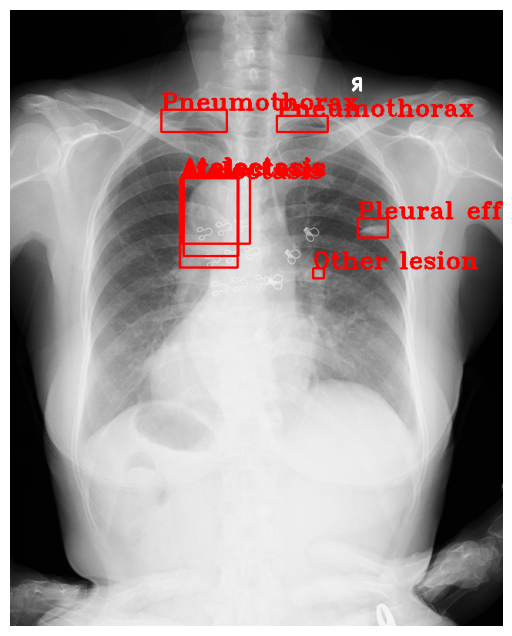

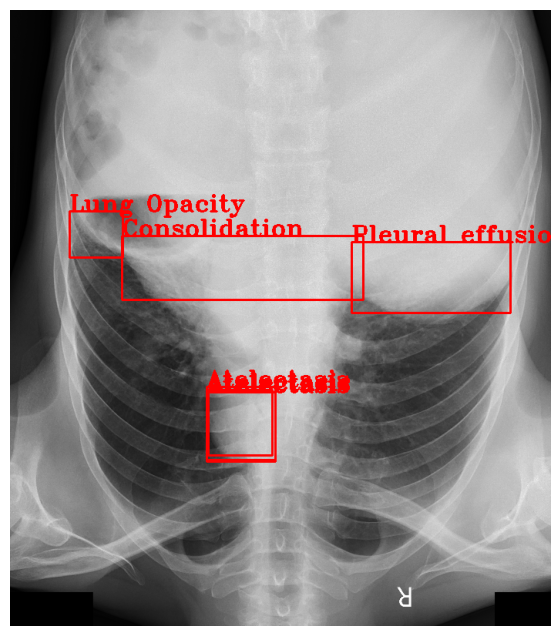

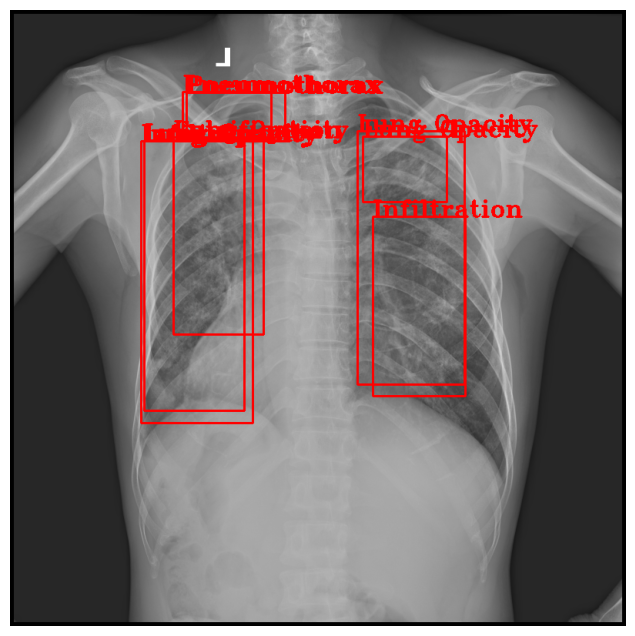

In [23]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))
print('1')
images = list(image.to(device) for image in images)
print('2')
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
print('3')

for number in random.sample([1,2,3],3):
  boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
  img = images[number].permute(1,2,0).cpu().numpy()
  labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  print('4')
  for i in range(len(boxes)):
      img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
      #print(le.inverse_transform([labels[i]-1])[0])
      #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
      img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

  ax.set_axis_off()
  ax.imshow(img)

In [19]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [20]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs =  2 #Low epoch to save GPU time

In [21]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [22]:
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []

import time
start = time.time()

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        print("test")
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)  
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

test


RuntimeError: CUDA out of memory. Tried to allocate 432.00 MiB (GPU 0; 22.20 GiB total capacity; 4.98 GiB already allocated; 239.06 MiB free; 5.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [28]:
import torchvision
print(torchvision.__path__)


['/home/ubuntu/anaconda3/envs/pytorch17_p38/lib/python3.8/site-packages/torchvision']


In [ ]:
import plotly.graph_objects as go

x = [i for i in range(num_epochs)]
y = lossHistoryepoch
fig = go.Figure()
fig.add_trace(go.Scatter(x=x,y=y,
                    mode='lines',
                    name='lines'))

fig.update_layout(title='Loss vs Epochs',
                   xaxis_title='Epochs',
                   yaxis_title='Loss')
fig.show()

In [ ]:
DIR_TEST = f'{DIR_INPUT}/test'
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')

In [ ]:
labels =  targets[1]['labels'].cpu().numpy()
model.eval()
cpu_device = torch.device("cpu")

In [ ]:
test_dataset = VinBigDataset(test_df, DIR_TEST, get_test_transform(),"Test")

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)


In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

## Sample Test Inputs

In [ ]:
# Test dataset sample
images, image_ids = next(iter(test_data_loader))
images = list(image.to(device) for image in images)

for number in random.sample([1,2,3],3):
  img = images[number].permute(1,2,0).cpu().numpy()
  #labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  ax.set_axis_off()
  ax.imshow(img)

## Sample Outputs

In [ ]:
images, image_ids = next(iter(test_data_loader))
images = list(img.to(device) for img in images)

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


boxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().detach().numpy()
labels= outputs[0]['labels'].cpu().detach().numpy().astype(np.int32)
score = outputs[0]['scores']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
for i in range(len(boxes)):
  img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),20)
  #print(le.inverse_transform([labels[i]-1])[0])
  #print(label_to_name(labels[i]), (boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize))
  img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,3, (255,0,0), 3, cv2.LINE_AA)

ax.set_axis_off()
ax.imshow(img)

In [ ]:

images = list(img.to(device) for img in images)

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


boxes = outputs[1]['boxes'].cpu().detach().numpy().astype(np.int32)
img = images[1].permute(1,2,0).cpu().detach().numpy()
labels= outputs[1]['labels'].cpu().detach().numpy().astype(np.int32)
score = outputs[1]['scores']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
for i in range(len(boxes)):
  img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),20)
  #print(le.inverse_transform([labels[i]-1])[0])
  #print(label_to_name(labels[i]), (boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize))
  img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,3, (255,0,0), 3, cv2.LINE_AA)


ax.set_axis_off()
ax.imshow(img)

In [ ]:

images = list(img.to(device) for img in images)

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


boxes = outputs[2]['boxes'].cpu().detach().numpy().astype(np.int32)
img = images[2].permute(1,2,0).cpu().detach().numpy()
labels= outputs[2]['labels'].cpu().detach().numpy().astype(np.int32)
score = outputs[2]['scores']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
for i in range(len(boxes)):
  img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),20)
  #print(le.inverse_transform([labels[i]-1])[0])
  #print(label_to_name(labels[i]), (boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize))
  img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,3, (255,0,0), 3, cv2.LINE_AA)

ax.set_axis_off()
ax.imshow(img)